<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CVAECifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
BATCH_SIZE = 100
LATENT_DIM = 2
EPOCHS = 300

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_train_indices = np.argwhere(train_labels == 0)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == 0)
class_test_images = test_images[class_test_indices[:,0]]

train_yuv  = tf.image.rgb_to_yuv(class_train_images)
train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
train_uv = train_yuv[:,:,:,1:]

test_yuv = tf.image.rgb_to_yuv(class_test_images)
test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
test_uv = test_yuv[:,:,:,1:]

In [90]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
# https://xiangyutang2.github.io/auto-colorization-autoencoders/

# Sampling with the reparametrisation trick
def sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

yuv_in = Input(shape=(train_yuv.shape[1], train_yuv.shape[2], train_yuv.shape[3]))

# Define Training Encoder q(z|yuv)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(yuv_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space for encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_training = Dense(LATENT_DIM)(layer)
z_log_var_training = Dense(LATENT_DIM)(layer)
z_training = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_training, z_log_var_training]) # Data passable to the decoder

# Instantiate encoder 
encoder_training = Model(yuv_in, z_training, name='training encoder')
encoder_training.summary()

Model: "training encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 16, 16, 8)    224         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_49[0][0]                  
___________________________________________________________________________________

In [91]:
y_in = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))

# Define Decoder p(uv|z,y)
latent_inputs = Input(shape=(LATENT_DIM,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
uv_out = Conv2DTranspose(filters=2, kernel_size=3, activation='sigmoid', padding='same')(layer)
concat_outputs = concatenate([uv_out, y_in], 3)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(concat_outputs)
mean_yuv = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same')(layer)
log_sig_sqr_yuv = Conv2DTranspose(filters=3, kernel_size=3, activation='relu', padding='same')(layer)

# Instantiate Decoder
decoder = Model([latent_inputs, y_in], mean_yuv, name='decoder')
decoder.summary()
yuv_out = decoder([z_training, y_in])

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 512)          1536        input_32[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 2, 2, 128)    0           dense_48[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_72 (Conv2DTran (None, 4, 4, 128)    147584      reshape_9[0][0]                  
____________________________________________________________________________________________

In [92]:
vae = Model([yuv_in, y_in], yuv_out, name='vae')
vae.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_31:0
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 16, 16, 8)    224         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 4, 4, 64)     9280        co

In [93]:
reconstruction_loss = K.sum(mse(yuv_in, yuv_out))
reconstruction_loss *= (train_yuv.shape[1] * train_yuv.shape[2])
kl_loss = 1 + z_log_var_training - K.square(z_mean_training) - K.exp(z_log_var_training)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 16, 16, 8)    224         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_49[0][0]                  
________________________________________________________________________________________________

In [94]:
history = vae.fit([train_yuv, train_y], shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([test_yuv, test_y], None))

Train on 5000 samples, validate on 1000 samples
Epoch 1/300
5000/5000 [==============================] - 2s 412us/sample - loss: 17091054.6600 - val_loss: 9911440.5000
Epoch 2/300
5000/5000 [==============================] - 1s 133us/sample - loss: 5959160.3350 - val_loss: 3387452.0000
Epoch 3/300
5000/5000 [==============================] - 1s 129us/sample - loss: 2143222.9075 - val_loss: 1045423.2937
Epoch 4/300
5000/5000 [==============================] - 1s 124us/sample - loss: 764216.2675 - val_loss: 589637.5750
Epoch 5/300
5000/5000 [==============================] - 1s 121us/sample - loss: 561896.4881 - val_loss: 527056.1031
Epoch 6/300
5000/5000 [==============================] - 1s 124us/sample - loss: 522233.1969 - val_loss: 504803.2313
Epoch 7/300
5000/5000 [==============================] - 1s 126us/sample - loss: 504496.3069 - val_loss: 494049.0375
Epoch 8/300
5000/5000 [==============================] - 1s 124us/sample - loss: 494447.9994 - val_loss: 483605.7906
Epoch 9/3

In [0]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(history.history["loss"][:], label="Training Image Loss")
plt.plot(history.history["val_loss"][:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

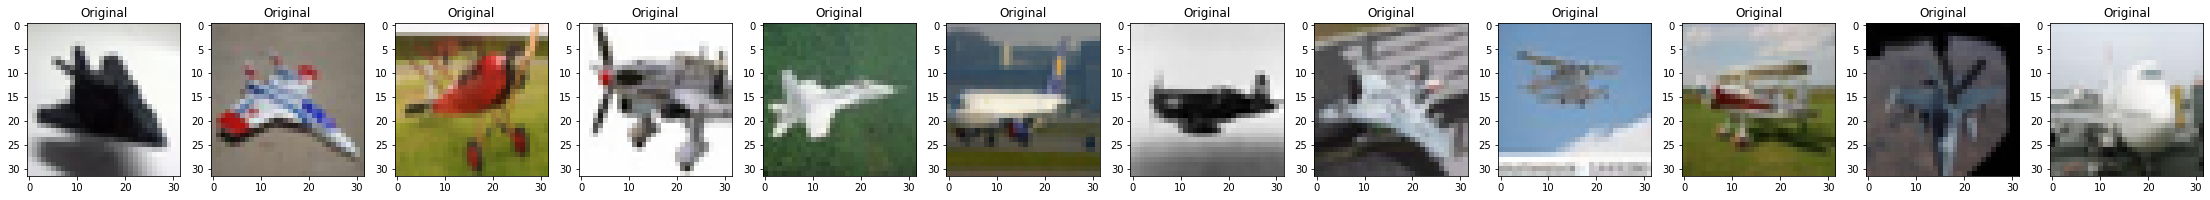

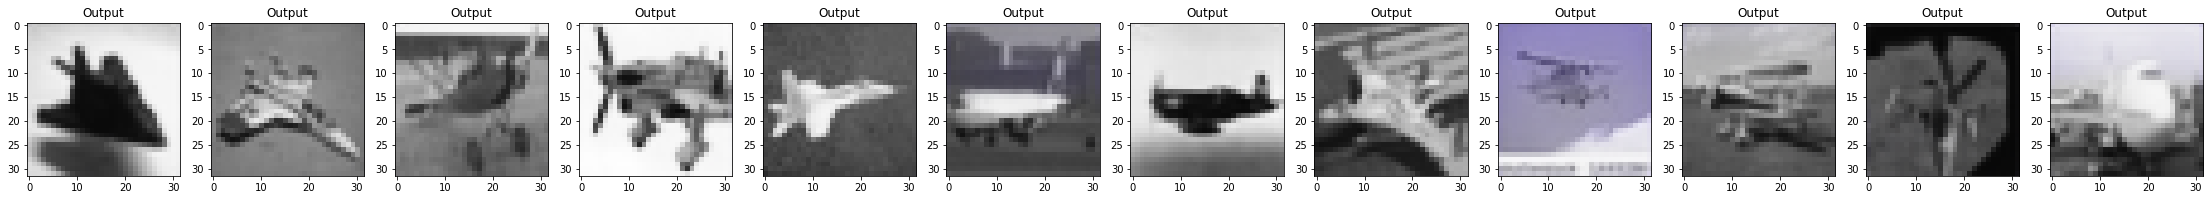

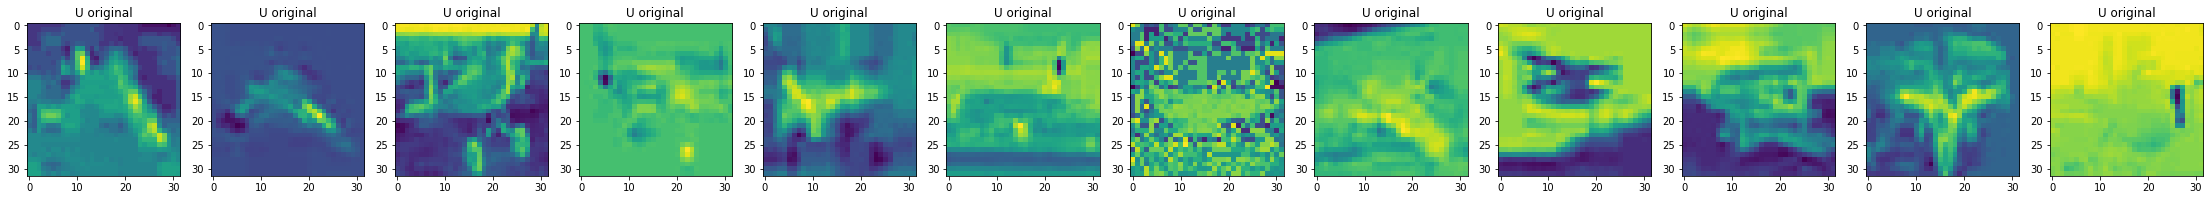

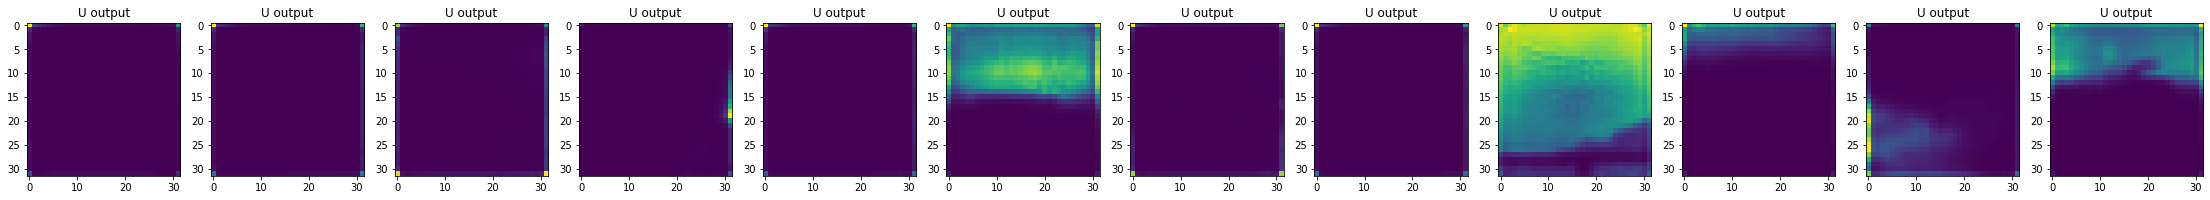

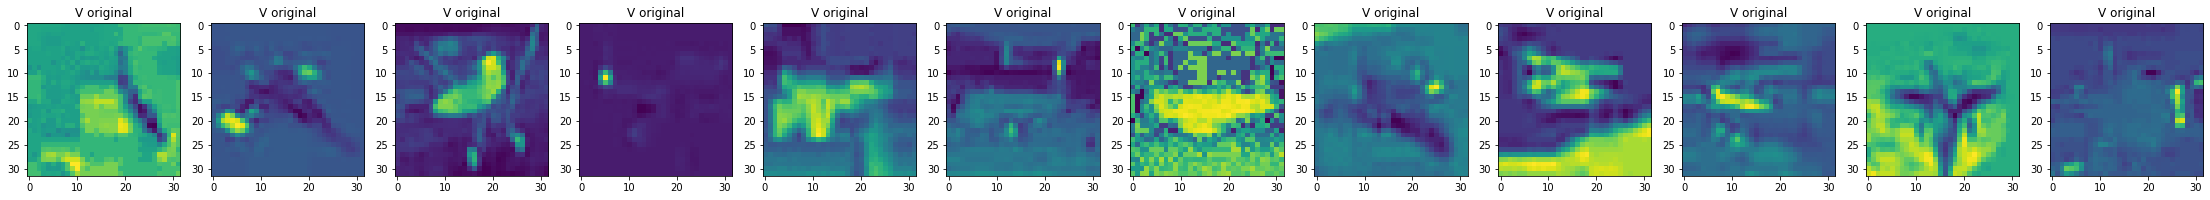

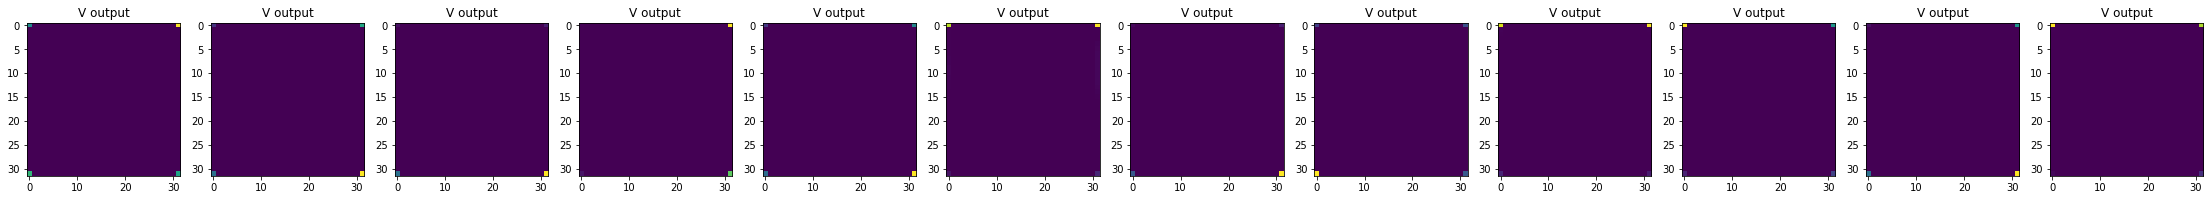

In [95]:
result = vae.predict([train_yuv, train_y])
# result = np.zeros((train_y.shape[0], 32, 32, 3))
# result[:,:,:,0] = train_y[:,:,:,0]
# result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_train_images[i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i,:,:,2])